In [364]:
import os
import json
import yaml
import uuid
import random
import itertools
from multiprocess.pool import ThreadPool

import tiktoken
from instructor import from_openai
from pydantic import BaseModel
from openai import OpenAI
from anthropic import Anthropic

import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
from IPython.display import HTML, display

usr = os.path.expanduser("~")

with open("openai.secret") as f:
    os.environ["OPENAI_API_KEY"] = f.read().strip()

set_matplotlib_formats("svg")

In [413]:
eval_data = pd.read_csv(
    "https://raw.githubusercontent.com/jancervenka/"
    "czech-simpleqa/refs/heads/main/src/czech_simpleqa/czech_simpleqa.csv.gz"
)
eval_data["uuid"] = [str(uuid.uuid4()) for _ in range(len(eval_data))]

model = "gpt-4o-mini"
# https://github.com/openai/tiktoken/blob/main/tiktoken/model.py#L12
# tokenizer = tiktoken.encoding_for_model(model)
tokenizer = tiktoken.get_encoding("o200k_base")
client = from_openai(OpenAI())

In [414]:
eval_data.head()

,metadata,problem,answer,translated_problem,translated_answer,uuid
0,"{'topic': 'Science and technology', 'answer_ty...",Who received the IEEE Frank Rosenblatt Award i...,Michio Sugeno,Kdo obdržel v roce 2010 cenu IEEE Frank Rosenb...,Michio Sugeno,763aa483-fd2c-4dbe-ad81-ae51f1641a60
1,"{'topic': 'Science and technology', 'answer_ty...",Who was awarded the Oceanography Society's Jer...,Annick Bricaud,Kdo obdržel Jerlovovu cenu od Oceanography Soc...,Annick Bricaud,99742f1f-0233-494d-ba85-e43f7efb3754
2,"{'topic': 'Geography', 'answer_type': 'Place',...",What's the name of the women's liberal arts co...,Radcliffe College,Jak se jmenuje ženská vysoká škola svobodných ...,Radcliffe College,fb5c5159-850b-42d2-92a4-0009abff0ced
3,"{'topic': 'Sports', 'answer_type': 'Person', '...",In whose honor was the Leipzig 1877 tournament...,Adolf Anderssen,Na počest koho byl zorganizován turnaj v Lipsk...,Adolf Anderssen,c4e89551-9d5d-4b81-b6e8-b0772fa54179
4,"{'topic': 'Art', 'answer_type': 'Person', 'url...","According to Karl Küchler, what did Empress El...",Poet Henrich Heine.,"Podle Karla Küchlera, co zobrazovala oblíbená ...",Básník Heinrich Heine.,de0423a5-3874-456d-8eda-38d983e7835f


In [415]:
def sample(
    eval_data: pd.DataFrame,
    n_repeats: int = 500,
    sample_size: int = 100,
) -> pd.DataFrame:
    stats = []
    for _ in tqdm.tqdm(range(n_repeats)):
        sample_problems = eval_data.sample(n=sample_size, replace=False)
        cs_problems = " ".join(sample_problems["translated_problem"].tolist())
        en_problems = " ".join(sample_problems["problem"].tolist())
        stats.append(
            {
                "cs_token_count": len(tokenizer.encode(cs_problems)),
                "en_token_count": len(tokenizer.encode(en_problems)),
                "cs_word_count": len(cs_problems.split(" ")),
                "en_word_count": len(en_problems.split(" ")),
            }
        )
    return pd.DataFrame(stats)

In [416]:
stats = sample(eval_data)

  0%|          | 0/500 [00:00<?, ?it/s]

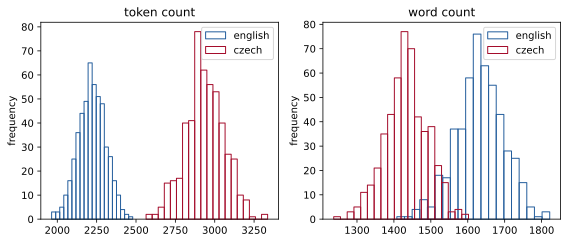

In [417]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3.5))
ax[0].hist(
    stats["en_token_count"], label="english", facecolor="none", bins=20, edgecolor="#235d9c"
)
ax[0].hist(
    stats["cs_token_count"], label="czech", facecolor="none", bins=20, edgecolor="#a40c2b"
)
ax[0].set_ylabel("frequency")
ax[0].set_title("token count")
ax[0].legend()

ax[1].hist(
    stats["en_word_count"], label="english", facecolor="none", bins=20, edgecolor="#235d9c"
)
ax[1].hist(
    stats["cs_word_count"], label="czech", facecolor="none", bins=20, edgecolor="#a40c2b"
)
ax[1].set_ylabel("frequency")
ax[1].set_title("word count")
ax[1].legend()
plt.tight_layout()

fig_path = os.path.join(
    usr, "Documents/site/assets/img/words_vs_tokens.svg"
)
plt.savefig(fig_path, transparent=True)
plt.show()

In [418]:
sample(eval_data, n_repeats=1, sample_size=len(eval_data))

  0%|          | 0/1 [00:00<?, ?it/s]

,cs_token_count,en_token_count,cs_word_count,en_word_count
0,126921,95953,61976,70588


In [419]:
def delimited_formatting(database: list[dict], delimiter: str) -> str:
    formatted_questions = [
        f"uuid: {q['uuid']}, question: {q['question']}" for q in database 
    ]
    return delimiter.join(formatted_questions)

In [420]:
def get_messages(
    database: list[dict],
    questions: list[dict],
    database_format: str,
    remove_noisy_token_prob: float = 0.0,
    delimiter: str | None = None
) -> list[dict]:

    if database_format == "yaml":
        formatted_database = yaml.dump(database, allow_unicode=True)
    elif database_format == "json":
        formatted_database = json.dumps(database, ensure_ascii=False, indent=2)
    elif database_format == "delimited":
        formatted_database = delimited_formatting(database, delimiter)
    else:
        raise ValueError()

    formatted_questions = "\n".join(f"question: {q['question']}" for q in questions)

    system_message = f"""You are a helpful assistant. You are given a database of many
different questions each associated with a UUID. Users will provide a list of {len(questions)}
questions and your goal is to retrieve the correct UUID from the database for each of
the questions. The database is included in this system prompt. Return just comma separated list
of {len(questions)} UUIDs and nothing else. The database:
{formatted_database}""".strip()

    if remove_noisy_token_prob > 0.0:
        system_message = remove_noisy_tokens(system_message, prob=remove_noisy_token_prob)

    user_message = f"{formatted_questions}"

    return [
         {"role": "system", "content": system_message},
         {"role": "user", "content": user_message}
    ]


class Response(BaseModel):
    uuids: list[str]


class FullResponse(BaseModel):
    pred_uuids: list[str]
    true_uuids: list[str]
    total_token_count: int
    semantic_token_count: int
    n_questions: int
    database_size: int
    language: str
    database_format: str


def call(messages: list[dict]) -> Response:
    return client.chat.completions.create(
        messages=messages,
        model=model,
        response_model=Response,
        max_tokens=4096,
    )


def get_total_token_count(messages: list[dict]) -> int:
    return len(tokenizer.encode(" ".join(m["content"] for m in messages)))


def get_semantic_token_count(database: list[dict], questions: list[dict]) -> int:
    database_text = " ".join(
        q["question"] + " " + q["uuid"] for q in database
    )
    questions_text = " ".join(q["question"] for q in questions)
    return len(tokenizer.encode(database_text + " " + questions_text))


def remove_noisy_tokens(message_content: str, prob: float) -> str:
    noisy_tokens = {
        tokenizer.encode(token)[0]
        for token in [
            ' "',
            '":',
            '   ',
            'uuid',
            'question',
            '",\n',
            ' {\n',
            ' },\n',
            '?"\n',
        ]
    }

    space_token = tokenizer.encode(" ")[0]  
    tokens = tokenizer.encode(message_content)
    # replace noisy tokens with a space with some probability
    noisy_tokens_removed = [
        space_token
        if token in noisy_tokens
        and np.random.rand() < prob else token
        for token in tokens
    ]
    # decode and replace any double/triple spaces that could have been
    # created by inserting a space token
    return (
        tokenizer
        .decode(noisy_tokens_removed)
        .replace("  ", " ")
        .replace("   ", " ")
        .replace("    ", " ")
    )

In [421]:
np.random.seed(0)
n_questions = 10
n_repeats = 10

eval_samples = []
for database_size in [100, 250, 500, 1000, 1500]:
    for _ in range(n_repeats):
        database = eval_data.sample(n=database_size, replace=False)
        questions = database.sample(n=n_questions, replace=False)
        eval_samples.append(
            {
                "database": database,
                "questions": questions
            }
        )

In [422]:
def get_response(
    database: pd.DataFrame,
    questions: pd.DataFrame,
    language: str,
    database_format: str,
    remove_noisy_token_prob: float = 0.0,
    delimiter: str | None = None,
) -> FullResponse:
    col = "problem" if language == "en" else "translated_problem"
    cols = ["uuid", col]
    how = {col: "question"}

    true_uuids = questions["uuid"].tolist()
    database = database[cols].rename(columns=how).to_dict("records")
    questions = questions[cols].rename(columns=how).to_dict("records")
    
    messages = get_messages(
        database=database,
        questions=questions, 
        database_format=database_format,
        remove_noisy_token_prob=remove_noisy_token_prob,
        delimiter=delimiter,
    )
    response = call(messages)
    return FullResponse(
        pred_uuids=response.uuids,
        true_uuids=true_uuids,
        language=language,
        database_format=database_format,
        database_size=len(database),
        n_questions=len(questions),
        total_token_count=get_total_token_count(messages),
        semantic_token_count=get_semantic_token_count(database, questions)
    )

In [423]:
test_matrix = [
    eval_samples,  # database + questions
    ["cs", "en"],  # language
    ["json", "yaml"],  # database_format
]

all_args = [
    {
        "eval_sample": eval_sample,
        "language": language,
        "database_format": database_format,
    }
    for eval_sample, language, database_format
    in itertools.product(*test_matrix)
]


def worker(eval_sample: dict, language: str, database_format: str) -> dict:    
    full_response = get_response(
        database=eval_sample["database"],
        questions=eval_sample["questions"],
        language=language,
        database_format=database_format,
    )
    return full_response.model_dump()


n_threads = 4
with ThreadPool(n_threads) as pool:
    results = list(tqdm.tqdm(pool.imap(lambda kw: worker(**kw), all_args), total=len(all_args)))

  0%|          | 0/200 [00:00<?, ?it/s]

In [424]:
with open("context_length_retrieval_results.json", "w") as f:
    json.dump(results, f)

In [425]:
def agg_results(results: list[dict] = None):

    if results is None:  
        with open("context_length_retrieval_results.json") as f:
            results = json.load(f)

    for r in results:
        r["correct"] = sum(map(lambda r: r[0] == r[1], zip(r["true_uuids"], r["pred_uuids"])))
        r["total"] = len(r["true_uuids"])

    groupby_key = ["database_size", "language", "database_format"]
    if "remove_noisy_token_prob" in results[0]:
        groupby_key.append("remove_noisy_token_prob")

    if "delimiter_length" in results[0]:
        groupby_key.append("delimiter_length")

    agg = (
        pd
        .DataFrame(results)
        .groupby(groupby_key)
        .agg(
            correct=("correct", "sum"),
            total=("total", "sum"),
            total_token_count=("total_token_count", "mean"),
            semantic_token_count=("semantic_token_count", "mean"),

        )
    )
    agg["semantic_token_ratio"] = agg["semantic_token_count"] / agg["total_token_count"]
    agg["accuracy"] = agg["correct"] / agg["total"]
    return agg.reset_index()

In [426]:
agg_results(results)

,database_size,language,database_format,correct,total,total_token_count,semantic_token_count,semantic_token_ratio,accuracy
0,100,cs,json,98,100,7156.4,5609.7,0.783872,0.98
1,100,cs,yaml,98,100,6539.4,5609.7,0.857831,0.98
2,100,en,json,98,100,6327.0,4782.9,0.755951,0.98
3,100,en,yaml,100,100,5727.1,4782.9,0.835135,1.00
4,250,cs,json,91,100,17267.5,13557.1,0.785122,0.91
5,250,cs,yaml,99,100,15739.1,13557.1,0.861364,0.99
6,250,en,json,95,100,15352.2,11647.2,0.758667,0.95
7,250,en,yaml,100,100,13867.5,11647.2,0.839892,1.00
8,500,cs,json,63,100,33964.2,26640.9,0.784382,0.63
9,500,cs,yaml,97,100,30900.2,26640.9,0.862159,0.97


In [427]:
eval_samples_500 = list(filter(lambda e: len(e["database"]) == 500, eval_samples))

test_matrix = [
    eval_samples_500,  # database (500) + questions
    [0.0, 0.1, 0.3, 0.5, 0.8, 1.0]  # remove noisy token probability
]

all_args = [
    {
        "eval_sample": eval_sample,
        "remove_noisy_token_prob": remove_noisy_token_prob,
    }
    for eval_sample, remove_noisy_token_prob
    in itertools.product(*test_matrix)
]


def worker(eval_sample: dict, remove_noisy_token_prob: float) -> dict:    
    full_response = get_response(
        database=eval_sample["database"],
        questions=eval_sample["questions"],
        language="en",
        database_format="json",
        remove_noisy_token_prob=remove_noisy_token_prob
    )
    return full_response.model_dump() | {"remove_noisy_token_prob": remove_noisy_token_prob}


n_threads = 4
with ThreadPool(n_threads) as pool:
    results_noisy_token_removal = list(
        tqdm.tqdm(
            pool.imap(
                lambda kw: worker(**kw), all_args
            ),
            total=len(all_args)
        )
    )

  0%|          | 0/60 [00:00<?, ?it/s]

In [428]:
agg_results(results_noisy_token_removal)

,database_size,language,database_format,remove_noisy_token_prob,correct,total,total_token_count,semantic_token_count,semantic_token_ratio,accuracy
0,500,en,json,0.0,73,100,30316.6,23004.3,0.758802,0.73
1,500,en,json,0.1,40,100,28656.4,23004.3,0.802763,0.40
2,500,en,json,0.3,17,100,27433.9,23004.3,0.838536,0.17
3,500,en,json,0.5,4,100,26348.5,23004.3,0.873078,0.04
4,500,en,json,0.8,1,100,24631.8,23004.3,0.933927,0.01
5,500,en,json,1.0,2,100,23158.4,23004.3,0.993346,0.02


In [438]:
eval_samples_500 = list(filter(lambda e: len(e["database"]) == 250, eval_samples))

test_matrix = [
    eval_samples_500,  # database (1500) + questions
    [
        " |\n",
        " " + "$~*\t@#" + "\n",
        " " + "$~*\t@#" * 20 + "\n",
        " " + "$~*\t@#" * 40 + "\n",
        " " + "$~*\t@#" * 80 + "\n",
    ]  # delimiter
]

all_args = [
    {
        "eval_sample": eval_sample,
        "delimiter": delimiter,
    }
    for eval_sample, delimiter
    in itertools.product(*test_matrix)
]


def worker(eval_sample: dict, delimiter: float) -> dict:    
    full_response = get_response(
        database=eval_sample["database"],
        questions=eval_sample["questions"],
        language="en",
        database_format="delimited",
        delimiter=delimiter,
    )
    return full_response.model_dump() | {"delimiter_length": len(delimiter)}


n_threads = 4
with ThreadPool(n_threads) as pool:
    results_delimited_formatting = list(
        tqdm.tqdm(
            pool.imap(
                lambda kw: worker(**kw), all_args
            ),
            total=len(all_args)
        )
    )

  0%|          | 0/50 [00:00<?, ?it/s]

In [439]:
agg_results(results_delimited_formatting)

,database_size,language,database_format,delimiter_length,correct,total,total_token_count,semantic_token_count,semantic_token_ratio,accuracy
0,250,en,delimited,3,96,100,13244.6,11647.2,0.879392,0.96
1,250,en,delimited,8,96,100,14489.6,11647.2,0.803832,0.96
2,250,en,delimited,122,86,100,38144.6,11647.2,0.305343,0.86
3,250,en,delimited,242,68,100,63044.6,11647.2,0.184745,0.68
4,250,en,delimited,482,44,100,112844.6,11647.2,0.103215,0.44


## Tokenization Viz

In [139]:
example_en = [
    {
        "question": "In what year did Etta Cone last visit Europe?"
    },
    {
        "question": "What was the original surname of conductor David Randolph?"
    }
]

text_en_json = json.dumps(example_en, indent=2)
text_en_yaml = yaml.dump(example_en)

In [140]:
example_en = [
    {
        "question": "Ve kterém roce Etta Cone naposledy navštívila Evropu?"
    },
    {
        "question": "Jaké bylo původní příjmení dirigenta Davida Randolpha?"
    }
]

text_cs_json = json.dumps(example_en, indent=2, ensure_ascii=False)
text_cs_yaml = yaml.dump(example_en, allow_unicode=True)

In [247]:
def get_html(text: str) -> str:
    opacity = 0.3
    colors = [
        f"rgba(164, 12, 43, {opacity})",
        f"rgba(35, 93, 156, {opacity})",
        f"rgba(12, 164, 133, {opacity})",
    ]

    def get_color(i: int) -> str:
        j = i % len(colors)
        color = colors[j]
        return f'style="background-color:{color}"'

    tokens = tokenizer.encode(text)
    html_elements = [
        f'<span {get_color(i)}>{tokenizer.decode([token])}</span>'
        for i, token in enumerate(tokens)
    ]

    return "<pre>" + "".join(html_elements) + "</pre>"

In [399]:
def html_to_svg(html_content: str, width: float = 800, height: float = 220) -> str:
     return f"""<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg xmlns="http://www.w3.org/2000/svg"
     xmlns:xlink="http://www.w3.org/1999/xlink"
     width="{width}" height="{height}">
  <foreignObject width="100%" height="100%">
    <body xmlns="http://www.w3.org/1999/xhtml">
      <div style="display: flex; justify-content: center; align-items: center; font-size: 18px;">
      {html_content}
      </div>
    </body>
  </foreignObject>
</svg>"""

In [404]:
html = get_html(text_en_json + "\n\n" + text_en_yaml)
display(HTML(html))
svg = html_to_svg(html, height=260)
print(len(tokenizer.encode(text_en_json)))
print(len(tokenizer.encode(text_en_yaml)))
with open(os.path.join(usr, "Documents/site/assets/img/text_en.svg"), "w") as f:
    f.write(svg)

41
27


In [406]:
html = get_html(text_en_yaml + "\n" + text_cs_yaml)
display(HTML(html))
svg = html_to_svg(html, height=150)
print(len(tokenizer.encode(text_en_yaml)))
print(len(tokenizer.encode(text_cs_yaml)))
with open(os.path.join(usr, "Documents/site/assets/img/text_cs.svg"), "w") as f:
    f.write(svg)

27
42
